## Advanced Lane Finding

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle
from ipywidgets import widgets
from IPython.display import display 
from IPython.display import Image
from ipywidgets import interactive, interact, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage import img_as_ubyte

### Set Up

In [22]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

    def update_coef_and_x(self, fit_detected, x_detected):
        if len(self.current_fit) <= 3:
            self.current_fit.append(fit_detected)
            self.recent_xfitted.append(x_detected)
        else:
            self.current_fit.append(fit_detected)
            self.recent_xfitted.append(x_detected)
            del self.current_fit[0]
            del self.recent_xfitted[0]
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        self.best_fit = np.mean(self.current_fit, axis=0)


    def get_diff_x(self, x_detected):
        if len(self.recent_xfitted) > 2:
            average_diff = np.mean(np.abs(self.bestx - x_detected))
            return average_diff

left_line = Line()
right_line = Line()

MTX = np.array([[  1.15662906e+03,   0.00000000e+00,   6.69041437e+02],
 [  0.00000000e+00,   1.15169194e+03,   3.88137240e+02],
 [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
DIST = np.array([[-0.2315715,  -0.12000537, -0.00118338,  0.00023305,  0.15641571]])

### Thresholding

In [23]:
# functions to get a good mask for an image
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*(abs_sobel/np.max(abs_sobel)))

    binary_output = scaled_sobel > thresh[0]
    binary_output = binary_output*(scaled_sobel < thresh[1])
    return binary_output


def filter_l_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_ch = hls[:,:,1]
    binary_output = np.zeros_like(l_ch)
    binary_output[(l_ch > thresh[0]) & (l_ch <= thresh[1])] = 1
    return binary_output


def filter_s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = hls[:,:,2]
    binary_output = np.zeros_like(s_ch)
    binary_output[(s_ch > thresh[0]) & (s_ch <= thresh[1])] = 1
    return binary_output



def thresholding(img):
    """Thresholding
    """             
    ksize=3
    # threshold image
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 190))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 190))
    s_binary = filter_s_select(img, thresh=(150, 255))
    l_binary = filter_l_select(img, thresh=(190, 250))
    
    combined = np.zeros_like(s_binary)
    combined[((gradx == 1) & (grady == 1)) | (s_binary == 1) | (l_binary == 1)] = 1
    combined_gray = np.uint8(255*combined)
    
    color_binary = np.zeros_like(gradx)
    color_binary = np.dstack(( combined_gray, combined_gray, combined_gray)).astype(np.float32)


    return color_binary.astype(np.float32), combined, s_binary

### Perspective transformation

In [24]:
#perspective transform on undistorted images
def perspective_transform(img):
    imshape = img.shape
    #print (imshape)
    vertices = np.array([[(.55*imshape[1], 0.63*imshape[0]), (imshape[1],imshape[0]),
                       (0,imshape[0]),(.45*imshape[1], 0.63*imshape[0])]], dtype=np.float32)
    #print (vertices)
    src= np.float32(vertices)
    dst = np.float32([[0.75*img.shape[1],0],[0.75*img.shape[1],img.shape[0]],
                      [0.25*img.shape[1],img.shape[0]],[0.25*img.shape[1],0]])
    #print (dst)
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (imshape[1], imshape[0]) 
    perspective_img = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)    
    return perspective_img, Minv


#region of interest
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img, dtype=np.uint8)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255                                                                    
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Extrapolate lines and draw them on the screen

In [25]:
def get_xy_points_curve(binary_warped, right_line, left_line):
    '''from udacity course'''
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)                                                       
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin

        win_xleft_high = leftx_current + margin                                                   
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),  2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >=        win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >=       win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty


def draw_lane(binary_warped):
    """Receives an image and returns a lane.
    """
           
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # get x and y coordinates for each line
    leftx, lefty, rightx, righty = get_xy_points_curve(binary_warped, right_line, left_line)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # measure the average difference between p
    diff_r = right_line.get_diff_x(right_fitx)

    diff_l = left_line.get_diff_x(left_fitx)

    if len(right_line.recent_xfitted) > 2:
        if diff_r < 160:
            right_line.update_coef_and_x(right_fit, right_fitx)
        if diff_l < 160:
            left_line.update_coef_and_x(left_fit, left_fitx)
    else:
        right_line.update_coef_and_x(right_fit, right_fitx)
        left_line.update_coef_and_x(left_fit, left_fitx)
    
    left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]

    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30./720 # meters per pixel in y dimension                                  
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters and dist from centre
    lane_centre = (left_fitx[-1] + right_fitx[-1])/2.0
    camera_centre = color_warp.shape[1]/2.0

    dist_centre_val = (lane_centre - camera_centre)*3.7/700
    avg_cur = (right_curverad+left_curverad)/2.0

    return color_warp, dist_centre_val, avg_cur

### Warp the lane onto the original image

In [26]:
def draw_on_original(img, lane, minv):
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(lane, minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.4, 0)
    return result

In [27]:
def pipeline(img, dist=DIST, mtx=MTX):
    #undistor the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #apply the thresholding operation
    thresh, grad_th, col_th = thresholding(undist)
    
    # filter for the region of interest.
    vertices = np.array([[(.55*img.shape[1], 0.6*img.shape[0]), (img.shape[1],img.shape[0]),
                        (0,img.shape[0]),(.45*img.shape[1], 0.6*img.shape[0])]], dtype=np.int32)
    region = region_of_interest(thresh.astype(np.uint8), vertices).astype(np.float32)

    #Perspective transformation
    perspective, minv = perspective_transform(region)
    perspective = cv2.cvtColor(perspective, cv2.COLOR_RGB2GRAY).astype(np.uint8)
   
    lane, center, curvature = draw_lane(perspective)
    mapped_lane = draw_on_original(img, lane, minv)
    font = cv2.FONT_HERSHEY_COMPLEX
    

    output = np.zeros((1080, 1440, 3), dtype=np.uint8)
    
    output[360:1080, 0:1200] = cv2.resize(mapped_lane, (1200,720), interpolation=cv2.INTER_AREA) 

    output[0:360, 0:360] = cv2.resize(img, (360,360), interpolation=cv2.INTER_AREA)   

    output[0:360, 360:720] = cv2.resize(undist, (360,360), interpolation=cv2.INTER_AREA)

    output[0:360, 720:1080] = cv2.resize(thresh*255, (360,360), interpolation=cv2.INTER_AREA)

    output[0:360,1080:1440] = cv2.resize(region*255, (360,360), interpolation=cv2.INTER_AREA) 

    output[360:720,1080:1440] = cv2.resize(np.dstack((perspective*255, perspective*255, perspective*255)), (360,360), interpolation=cv2.INTER_AREA) 

    output[720:1080,1080:1440] = cv2.resize(lane, (360,360), interpolation=cv2.INTER_AREA) 

    cv2.putText(output,'curvature: {0} m'.format(int(curvature)),(0,400), font, 2,(255,255,255),2)

    cv2.putText(output,'car is {0:.2f} m off center'.format(center),(0,440), font, 1.6,(255,255,255),2)
    
    return output

In [28]:
white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:07<00:00,  5.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 13min 51s, sys: 8.7 s, total: 14min
Wall time: 4min 8s


In [29]:
HTML("""
<video width="900" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [37]:
img = cv2.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(img.astype(np.float32), MTX, DIST, None, MTX)
cv2.imwrite('undist.jpg', undist)

True

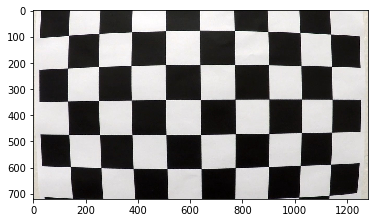

In [36]:
plt.imshow(mpimg.imread('camera_cal/calibration1.jpg'))

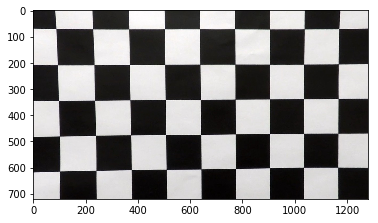

In [38]:
plt.imshow(mpimg.imread('undist.jpg'))